In [1]:
import anndata as ad 
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import scanpy
import seaborn as sns 
import sklearn.metrics.pairwise
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm

n_uV_per_mV = 1000
n_mV_per_V = 1000
n_ms_per_s = 1000
window_ms, bin_ms = 100, 1.5

plot_format = 'pdf'
figure_folder = 'data/figures/longterm-v3'
os.makedirs(figure_folder, exist_ok=True)

In [2]:
threshold = 3.0
curated_units = {
    # subject, surgery_date, n_segment
    ('1_5', '20230627', 12): {
        # (shank, threshold): ([less confident units], [more confident units])
        4: {
            1: [2, 3, 5, 6, 9],
            2: [2, 3, 5, 6, 9],
            # 3: [2, 3, 5, 6, 11],
            15: [2, 3, 5, 6, 9],
            20: [2, 3, 5, 6, 10],
            22: [2, 3, 5, 6],
        },
        0: {
        },
        1: {
            1: [1, 4, 5, 6, 10],
            2: [   4, 5, 6, 10],
            4: [2, 4, 5, 6, 10],
            5: [2, 4, 5, 6, 10],
            6: [   4, 5, 6, 10],
        },
        2: {
            1: [2, 4, 5, 6, 11],
            2: [2, 4, 5, 6, 11],
            3: [2, 4, 5, 6, 10],
            4: [1, 4, 5, 6, 10],
            5: [1, 4, 5, 6, 10],
            8: [2, 4, 5, 6, 10],
        },
        3: {
            1: [1, 4, 5, 6, 10],
            2: [0, 4, 5, 6, 9],
            3: [   4, 5, 6, 11],
            4: [0, 4, 5, 7, 11],
            5: [0, 4, 5, 6, 11],
            6: [0, 4, 5, 6, 11],
        },
    }
}

plotted_units = {
    '1_5': [(2, 1), (2, 2), (2, 3), (3, 4), (2, 4), (2, 8), (3, 1), (3, 2), (4, 1), (4, 2), (4, 15)]
}

channel_indices = np.array([
    [ 5,  3,  1,  7,  9, 11], # 5
    [17, 15, 13, 19, 21, 23], # 4
    [29, 27, 25, 28, 26, 24], # 3
    [18, 20, 22, 16, 14, 12], # 2
    [ 6,  8, 10,  4,  2,  0], # 1
])
inter_electrode_distance = 50
n_total_lapse = 18 
n_shank = 5
n_channel = 6
lapses_plotted = [2, 6, 10, 14, 18]

n_unit = sum([len(shank_units) for shank_curated_units in curated_units.values() for shank_units in shank_curated_units.values()])

In [3]:
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    os.makedirs(f'data/processed/{subject}/adata', exist_ok=True)
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            if not os.path.isfile(f'data/processed/{subject}/adata/shank{shank}_unit{unit_id}.h5ad'):
                session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
                segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
                recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
                sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
                waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]

                xs, labels = [], []
                for segment in unit_segments:
                    segment_waveforms = waveform_extractors[segment].get_waveforms(unit_id=unit_id)
                    segment_waveforms = segment_waveforms.reshape(segment_waveforms.shape[0], segment_waveforms.shape[1]*segment_waveforms.shape[2])
                    xs.append(segment_waveforms)
                    labels.append([segment_lapses[segment]] * len(segment_waveforms))
                xs = np.vstack(xs)
                labels = np.hstack(labels)
                unit_adata = ad.AnnData(X=xs, obs=pd.DataFrame({'lapse': labels}))
                scanpy.pp.neighbors(unit_adata, use_rep='X')
                scanpy.tl.umap(unit_adata)
                unit_adata.write_h5ad(f'data/processed/{subject}/adata/shank{shank}_unit{unit_id}.h5ad')

In [4]:
subject = '1_5'
segment = 3
recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for shank in range(n_shank)]
n_frames_per_ms = recordings[0].sampling_frequency / n_ms_per_s
shank_gap = 100
trace_gap = 50

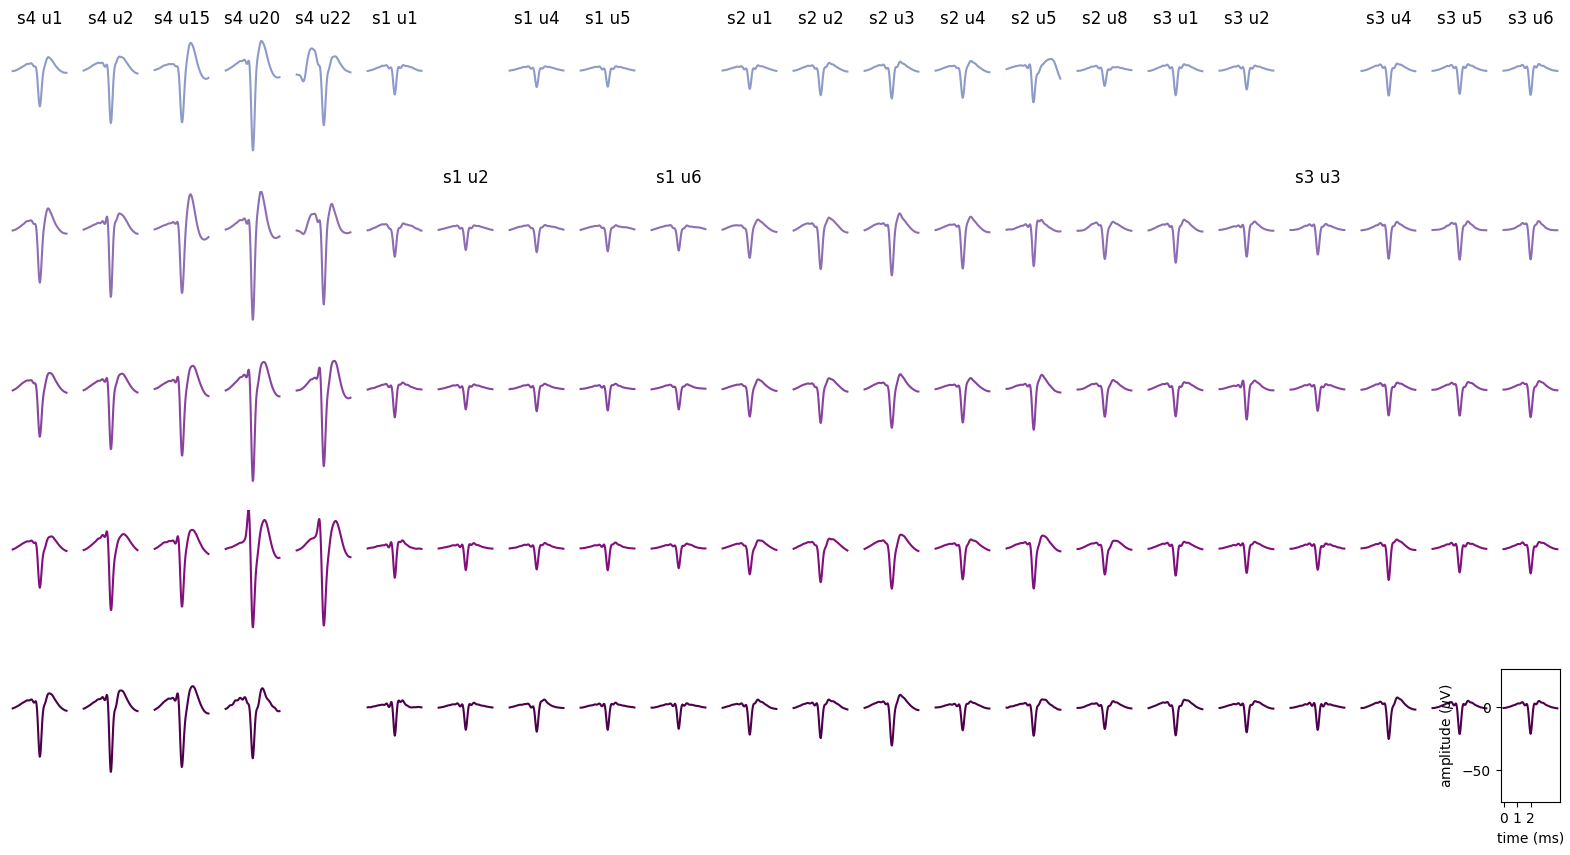

In [5]:
fig = plt.figure(figsize=(20, 10))
unit_index = 0
template_gap = 15
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
            templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
            unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])
            
            extremum_channels = [sc.get_template_extremum_channel(waveform_extractors[segment])[unit_id] for segment in range(n_segment)]
            extremum_channels = [np.where(channel_indices[shank] == extremum_channel)[0].item() for extremum_channel in extremum_channels]
            extremum_templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id)[:, extremum_channels[segment]] for segment in range(n_segment)])

            for plot_index, segment in enumerate(unit_segments):
                row = lapses_plotted.index(segment_lapses[segment])
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                ax = plt.subplot(len(lapses_plotted), n_unit, (row * n_unit)+unit_index+1)
                ax.plot(extremum_templates[segment], color=color)
                ax.set_ylim(-75, 30)
                ax.set_axis_off()
                if plot_index == 0: 
                    ax.set_title(f's{shank} u{unit_id}')
            unit_index += 1
ax.set_axis_on()
ax.set_xticks([0, n_frames_per_ms, n_frames_per_ms * 2], [0, 1, 2])
ax.set_xlabel('time (ms)')
ax.set_ylabel(r'amplitude ($\mu$V)')
plt.savefig(f'{figure_folder}/templates.{plot_format}')
plt.show()
plt.close()

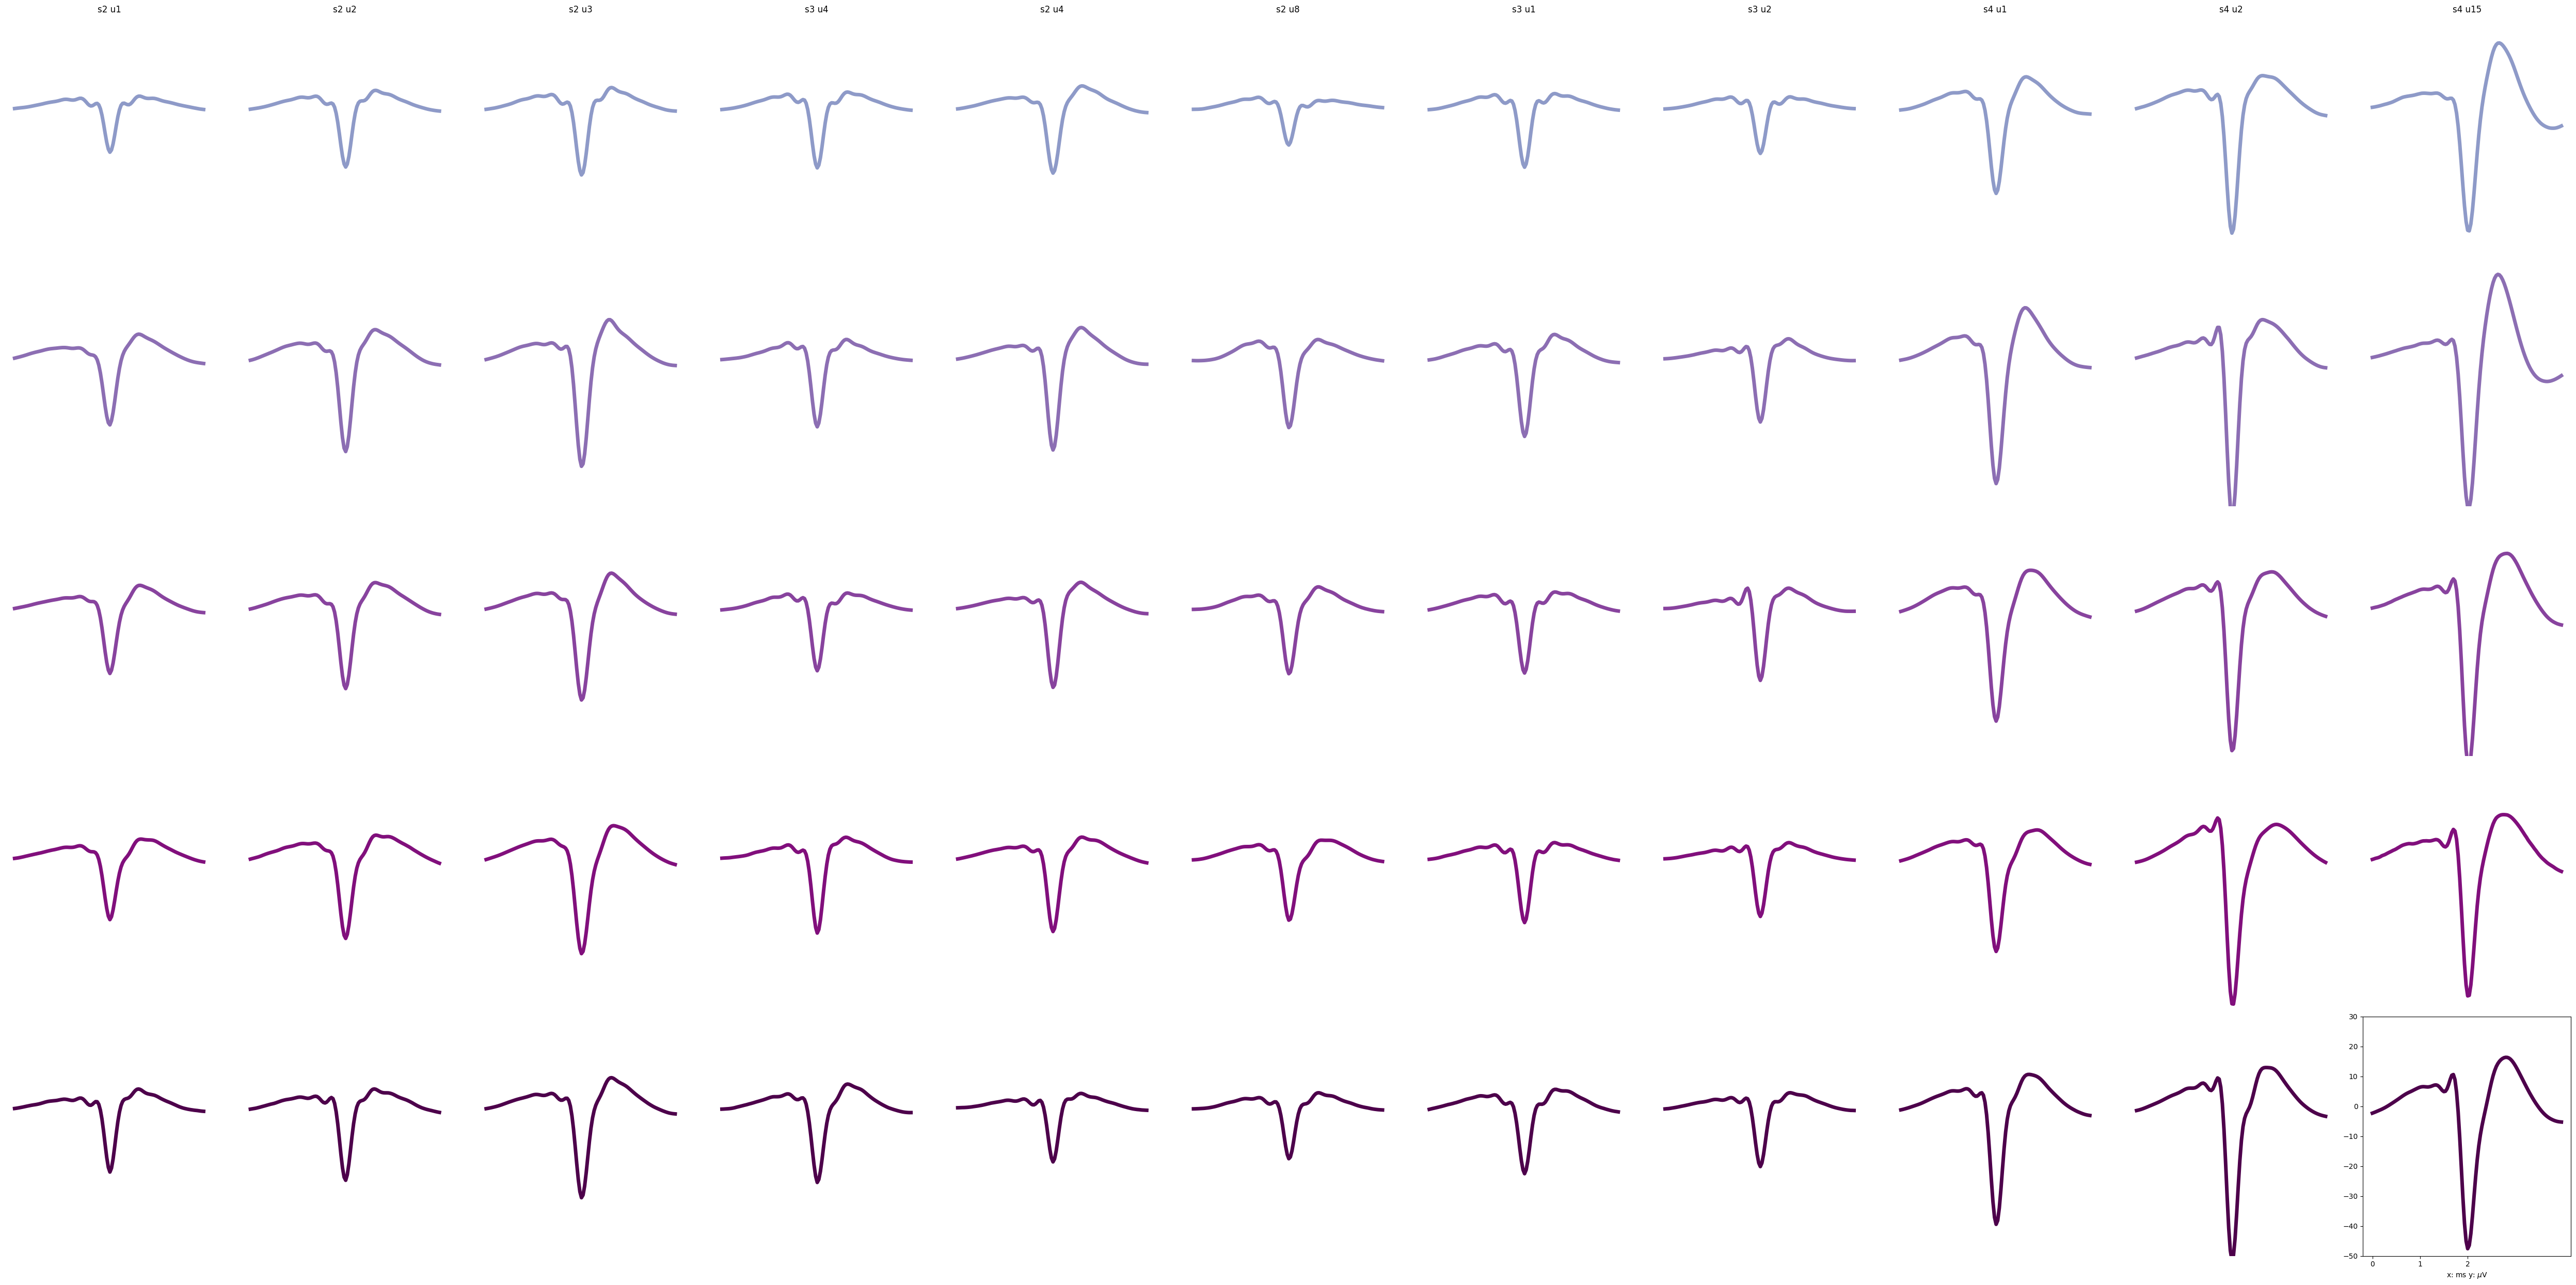

In [6]:
fig = plt.figure(figsize=(50, 25))
unit_index = 0
template_gap = 15
for key, subject_curated_units in curated_units.items():
    (subject, surgery_date, n_segment) = key
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for (shank, unit_id) in plotted_units[subject]:
        unit_segments = curated_units[key][shank][unit_id]
        session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
        segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
        recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
        sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
        waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
        templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
        unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])
        
        extremum_channels = [sc.get_template_extremum_channel(waveform_extractors[segment])[unit_id] for segment in range(n_segment)]
        extremum_channels = [np.where(channel_indices[shank] == extremum_channel)[0].item() for extremum_channel in extremum_channels]
        extremum_templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id)[:, extremum_channels[segment]] for segment in range(n_segment)])

        for plot_index, segment in enumerate(unit_segments):
            row = lapses_plotted.index(segment_lapses[segment])
            color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
            ax = plt.subplot(len(lapses_plotted), len(plotted_units[subject]), (row * len(plotted_units[subject])+unit_index+1))
            ax.plot(extremum_templates[segment], color=color, linewidth=5)
            ax.set_ylim(-50, 30)
            ax.set_axis_off()
            if plot_index == 0: 
                ax.set_title(f's{shank} u{unit_id}')
        unit_index += 1
ax.set_axis_on()
ax.set_xticks([0, n_frames_per_ms, n_frames_per_ms * 2], [0, 1, 2])
ax.set_xlabel(r'x: ms y: $\mu$V')
plt.tight_layout()
plt.savefig(f'{figure_folder}/templates_arranged.{plot_format}')
plt.show()
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


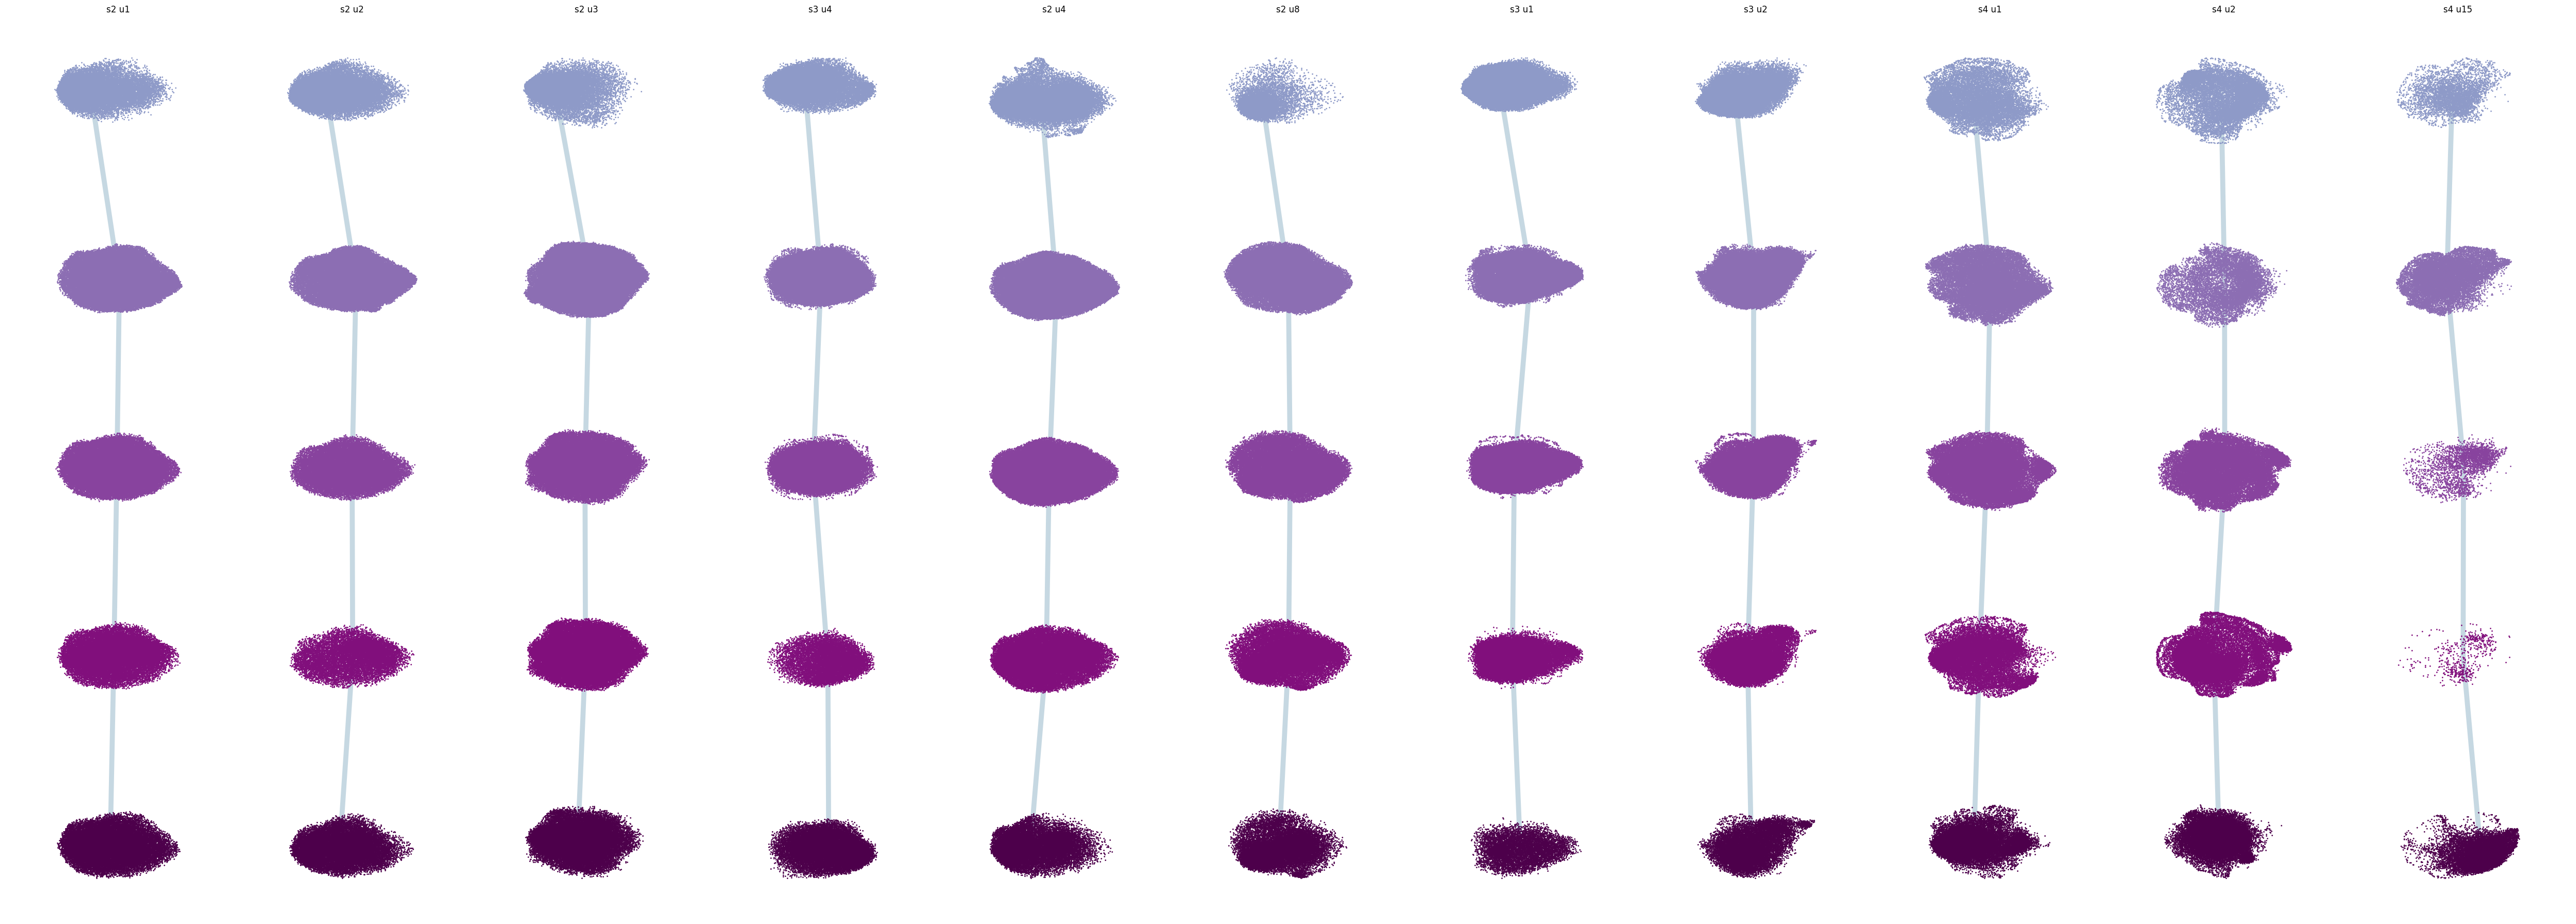

In [7]:
fig = plt.figure(figsize=(50, 18))
lapse_gap = 30
unit_spacer = 5
for key, subject_curated_units in curated_units.items():
    (subject, surgery_date, n_segment) = key
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for unit_index, (shank, unit_id) in enumerate(plotted_units[subject]):
        unit_adata = ad.read_h5ad(f'data/processed/{subject}/adata/shank{shank}_unit{unit_id}.h5ad')
        means = []
        
        ax = plt.subplot(1, len(plotted_units[subject]), unit_index+1)
        ax.set_title(f's{shank} u{unit_id}')
        ax.set_axis_off()
        for plot_index, lapse in enumerate(lapses_plotted):
            lapse_adata = unit_adata[unit_adata.obs['lapse'] == lapse]
            row = lapses_plotted.index(lapse)
            color = plt.cm.BuPu(0.42 + 0.58 * lapse/n_total_lapse)

            ax.scatter(lapse_adata.obsm['X_umap'][:, 0], lapse_adata.obsm['X_umap'][:, 1] - row * lapse_gap, s=1, color=color, zorder=10)
            means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean() - row * lapse_gap])

        means = np.array(means)
        ax.plot(means[:, 0], means[:, 1], linewidth=7, alpha=0.5, color='#8FB3C6', zorder=0)
        ax.set_xlim(unit_adata.obsm['X_umap'][:, 0].min()-unit_spacer, unit_adata.obsm['X_umap'][:, 0].max()+unit_spacer)
plt.tight_layout()
plt.savefig(f'{figure_folder}/umaps_arranged.pdf')
plt.savefig(f'{figure_folder}/umaps_arranged.eps')
plt.savefig(f'{figure_folder}/umaps_arranged.svg')
plt.savefig(f'{figure_folder}/umaps_arranged.png', dpi=600, transparent=True)
plt.show()
plt.close()